In [108]:
# shared across tasks
from plb.optimizer.optim import Adam
from plb.engine.taichi_env import TaichiEnv
from plb.config.default_config import get_cfg_defaults, CN

import os
import cv2
import numpy as np
import taichi as ti
ti.init(arch=ti.gpu)
import matplotlib.pyplot as plt
from plb.config import load
from tqdm.notebook import tqdm

[Taichi] Starting on arch=cuda


ENV:
  loss:
    soft_contact: False
    target_path: envs/assets/Chopsticks3D-v1.npy
    weight:
      contact: 1
      density: 10
      sdf: 10
  n_observed_particles: 200
PRIMITIVES: [{'shape': 'Capsule', 'h': 0.2, 'r': 0.045, 'init_pos': '(0.35, 0.4, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 1.0, 'action': {'dim': 6, 'scale': '(0.02, 0.02, 0.02, 0.04, 0.04, 0.04)'}}, {'shape': 'Capsule', 'h': 0.2, 'r': 0.045, 'init_pos': '(0.65, 0.4, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 1.0, 'action': {'dim': 6, 'scale': '(0.02, 0.02, 0.02, 0.04, 0.04, 0.04)'}}, {'shape': 'Capsule', 'h': 0.13, 'r': 0.025, 'init_pos': '(0.5, 0.1, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.2, 0.2, 0.2)', 'friction': 15.0}]
RENDERER:
  bake_size: 6
  camera_pos: (0.5, 1.2, 4.0)
  camera_pos_1: (0.5, 2.5, 2.2)
  camera_pos_2: (0.5, 2.5, 2.2)
  camera_pos_3: (0.5, 2.5, 2.2)
  camera_pos_4: (0.5, 2.5, 2.2)
  camera_rot: (0.2, 0)
  ca

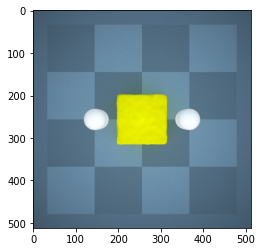

In [109]:
task_name = 'ngrip'
env_type = '_fixed'

# gripper_fixed.yml
cfg = load(f"../envs/gripper{env_type}.yml") 
print(cfg)
env = TaichiEnv(cfg, nn=False, loss=False)
env.initialize()
state = env.get_state()

env.set_state(**state)
taichi_env = env
print(env.renderer.camera_pos)
env.renderer.camera_pos[0] = 0.5
env.renderer.camera_pos[1] = 2.5
env.renderer.camera_pos[2] = 0.5
env.renderer.camera_rot = (1.57, 0.0)

env.primitives.primitives[0].set_state(0, [0.3, 0.4, 0.5, 1, 0, 0, 0])
env.primitives.primitives[1].set_state(0, [0.7, 0.4, 0.5, 1, 0, 0, 0])

env.render('plt')

action_dim = taichi_env.primitives.action_dim

In [110]:
env.primitives.action_dim

12

In [111]:
cwd = os.getcwd()
root_dir = cwd + "/../.."
print(f'root: {root_dir}')

task_params = {
    "mid_point": np.array([0.5, 0.14, 0.5, 0, 0, 0]),
    "sample_radius": 0.4,
    "len_per_grip": 30,
    "len_per_grip_back": 10,
    "floor_pos": np.array([0.5, 0, 0.5]),
    "n_shapes": 3, 
    "n_shapes_floor": 9,
    "n_shapes_per_gripper": 11,
    "gripper_mid_pt": int((11 - 1) / 2),
    "gripper_rate_limits": np.array([0.14, 0.06]), # ((0.4 * 2 - (0.23)) / (2 * 30), (0.4 * 2 - 0.15) / (2 * 30)),
    "p_noise_scale": 0.01,
}

if env_type == '':
    task_params["p_noise_scale"] = 0.03

print(f'p_noise_scale: {task_params["p_noise_scale"]}')

root: /home/ianpedroza/RoboCraft/simulator/plb/algorithms/../..
p_noise_scale: 0.01


In [112]:
def set_parameters(env: TaichiEnv, yield_stress, E, nu):
    env.simulator.yield_stress.fill(yield_stress)
    _mu, _lam = E / (2 * (1 + nu)), E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame parameters
    env.simulator.mu.fill(_mu)
    env.simulator.lam.fill(_lam)


def update_camera(env):
    env.renderer.camera_pos[0] = 0.5
    env.renderer.camera_pos[1] = 2.5
    env.renderer.camera_pos[2] = 0.5
    env.renderer.camera_rot = (1.57, 0.0)
    # env.render_cfg.defrost()
    # env.render_cfg.camera_pos_1 = (0, 2.5, 0)  # Positioned directly above
    # env.render_cfg.camera_rot_1 = (0.0, 0.0)
    # env.render_cfg.camera_pos_2 = (2.4, 2.5, 0.2)
    # env.render_cfg.camera_rot_2 = (0.8, 1.8)
    # env.render_cfg.camera_pos_3 = (-1.9, 2.5, 0.2)
    # env.render_cfg.camera_rot_3 = (0.8, -1.8)
    # env.render_cfg.camera_pos_4 = (0.5, 2.5, -1.8)
    # env.render_cfg.camera_rot_4 = (0.8, 3.14)


def update_primitive(env, prim1_list, prim2_list):
    env.primitives.primitives[0].set_state(0, prim1_list)
    env.primitives.primitives[1].set_state(0, prim2_list)


def save_files(env, rollout_dir, i):
    files = glob.glob(f"{root_dir}/dataset/{task_name}/{i:03d}/*")
    for f in files:
        os.remove(f)
        
    os.makedirs(f"{rollout_dir}/{i:03d}", exist_ok=True)
    with open(f"{rollout_dir}/{i:03d}"+"/cam_params.npy", 'wb') as f:
        ext1=env.renderer.get_ext(env.render_cfg.camera_rot_1, np.array(env.render_cfg.camera_pos_1))
        ext2=env.renderer.get_ext(env.render_cfg.camera_rot_2, np.array(env.render_cfg.camera_pos_2))
        ext3=env.renderer.get_ext(env.render_cfg.camera_rot_3, np.array(env.render_cfg.camera_pos_3))
        ext4=env.renderer.get_ext(env.render_cfg.camera_rot_4, np.array(env.render_cfg.camera_pos_4))
        intrinsic = env.renderer.get_int()
        cam_params = {'cam1_ext': ext1, 'cam2_ext': ext2, 'cam3_ext': ext3, 'cam4_ext': ext4, 'intrinsic': intrinsic}
        np.save(f, cam_params)


from transforms3d.quaternions import mat2quat
from transforms3d.axangles import axangle2mat
def random_rotate(mid_point, gripper1_pos, gripper2_pos, z_vec):
    mid_point = mid_point[:3]
    z_angle = np.random.uniform(0, np.pi)
    z_mat = axangle2mat(z_vec, z_angle, is_normalized=True)
    all_mat = z_mat
    quat = mat2quat(all_mat)
    return gripper1_pos, gripper2_pos, quat


def random_pose(task_name):
    p_noise_x = task_params["p_noise_scale"] * (np.random.randn() * 2 - 1)
    p_noise_z = task_params["p_noise_scale"] * (np.random.randn() * 2 - 1)
    if task_name == 'ngrip' or task_name == 'ngrip_3d':
        p_noise = np.clip(np.array([p_noise_x, 0, p_noise_z]), a_min=-0.1, a_max=0.1)
    else:
        raise NotImplementedError
    
    new_mid_point = task_params["mid_point"][:3] + p_noise

    rot_noise = np.random.uniform(0, np.pi)

    x1 = new_mid_point[0] - task_params["sample_radius"] * np.cos(rot_noise)
    z1 = new_mid_point[2] + task_params["sample_radius"] * np.sin(rot_noise)
    x2 = new_mid_point[0] + task_params["sample_radius"] * np.cos(rot_noise)
    z2 = new_mid_point[2] - task_params["sample_radius"] * np.sin(rot_noise)
    y = new_mid_point[1]
    z_vec = np.array([np.cos(rot_noise), 0, np.sin(rot_noise)])
    if task_name == 'ngrip':
        gripper1_pos = np.array([x1, y, z1])
        gripper2_pos = np.array([x2, y, z2])
        quat = np.array([1, 0, 0, 0])
    elif task_name == 'ngrip_3d':
        gripper1_pos, gripper2_pos, quat = random_rotate(new_mid_point, np.array([x1, y, z1]), np.array([x2, y, z2]), z_vec)
    else:
        raise NotImplementedError
    
    direction = new_mid_point - gripper1_pos
    rotation = np.arctan2(direction[2], direction[0])

    return np.concatenate([gripper1_pos, quat]), np.concatenate([gripper2_pos, quat]), rotation


def get_obs(env, n_particles, t=0):
    x = env.simulator.get_x(t)
    v = env.simulator.get_v(t)
    step_size = len(x) // n_particles
    return x[::step_size], v[::step_size]


def select_tool(env, width):
    env.primitives.primitives[0].r[None] = width
    env.primitives.primitives[1].r[None] = width


In [113]:
def calculate_gripper_positions(midpoint, rotation, sample_radius):
    """
    Calculate the original positions of gripper1 and gripper2 given the midpoint and rotation.

    Parameters:
        midpoint (numpy.ndarray): The 3D coordinates of the midpoint (x, y, z).
        rotation (float): The rotation angle (in radians) returned by random_pose.
        sample_radius (float): The distance from the midpoint to each gripper.

    Returns:
        gripper1_pos (numpy.ndarray): The position of gripper1 (x, y, z).
        gripper2_pos (numpy.ndarray): The position of gripper2 (x, y, z).
    """
    x1 = midpoint[0] - sample_radius * np.cos(rotation)
    z1 = midpoint[2] + sample_radius * np.sin(rotation)

    x2 = midpoint[0] + sample_radius * np.cos(rotation)
    z2 = midpoint[2] - sample_radius * np.sin(rotation)

    y = midpoint[1]  # The y-coordinate remains the same for both grippers.

    gripper1_pos = np.array([x1, y, z1])
    gripper2_pos = np.array([x2, y, z2])

    return gripper1_pos, gripper2_pos

def convert_constrained_to_action(constrained_state):
    """Convert constrained representation back to full action."""
    rotation = constrained_state['rotation']
    
    # Direction vector can be directly calculated from rotation
    direction = np.array([
        np.cos(rotation),
        0,  # y component is always 0 since movement is horizontal
        np.sin(rotation)
    ])
    
    rate = 0.02
    prim1_action = rate * direction
    zero_pad = np.array([0, 0, 0])
    
    return np.concatenate([prim1_action/0.02, zero_pad, -prim1_action/0.02, zero_pad])

In [116]:
import glob
from datetime import datetime
from tqdm.notebook import tqdm

i = 0
n_vid = 10
suffix = ''
n_grips = 3
zero_pad = np.array([0,0,0])

time_now = datetime.now().strftime("%d-%b-%Y-%H:%M:%S.%f")
rollout_dir = f"{root_dir}/dataset/{task_name}{env_type}{suffix}_{time_now}"

while i < n_vid: 
    print(f"+++++++++++++++++++{i}+++++++++++++++++++++")
    env.set_state(**state)
    taichi_env = env    
    # update_camera(env)
    set_parameters(env, yield_stress=200, E=5e3, nu=0.2) # 200， 5e3, 0.2 # 300, 800, 0.2
    update_primitive(env, [0.3, 0.4, 0.5, 1, 0, 0, 0], [0.7, 0.4, 0.5, 1, 0, 0, 0])
    save_files(env, rollout_dir, i)
    action_dim = env.primitives.action_dim
    imgs = [] 
    true_idx = 0
    for k in range(n_grips):
        
        prim1, prim2, cur_angle = random_pose(task_name)
        # test_prim = prim1 * 10
        # update_primitive(env, test_prim, test_prim)
        update_primitive(env, prim1, prim2)
        
        if 'small' in suffix:
            tool_size = 0.025
        else:
            tool_size = 0.045
        select_tool(env, tool_size)
        
        gripper_rate_limit = [(task_params['sample_radius'] * 2 - (task_params['gripper_rate_limits'][0] + 2 * tool_size)) / (2 * task_params['len_per_grip']),
                              (task_params['sample_radius'] * 2 - (task_params['gripper_rate_limits'][1] + 2 * tool_size)) / (2 * task_params['len_per_grip'])]
        rate = np.random.uniform(*gripper_rate_limit)
        actions = []
        counter = 0 
        mid_point = (prim1[:3] + prim2[:3]) / 2
        # old_prim1_direction = mid_point - prim1[:3]
        # old_prim1_direction = old_prim1_direction / np.linalg.norm(old_prim1_direction)
        # print(old_prim1_direction)

        direction = np.array([
            np.cos(cur_angle),
            0,  # y component is always 0 since movement is horizontal
            np.sin(cur_angle)
        ])
        prim1_direction = direction / np.linalg.norm(direction)

        while counter < task_params["len_per_grip"]:
            prim1_action = rate * prim1_direction
            actions.append(np.concatenate([prim1_action/0.02, zero_pad, -prim1_action/0.02, zero_pad]))
            counter += 1
        counter = 0
        while counter < task_params["len_per_grip_back"]:
            prim1_action = -rate * prim1_direction
            actions.append(np.concatenate([prim1_action/0.02, zero_pad, -prim1_action/0.02, zero_pad]))
            counter += 1

        actions = np.stack(actions)
            
        for idx, act in enumerate(tqdm(actions, total=actions.shape[0])):
            env.step(act)
            obs = get_obs(env, 300)
            x = obs[0][:300]
            
            primitive_state = [env.primitives.primitives[0].get_state(0), env.primitives.primitives[1].get_state(0)]

            img = env.render(mode='rgb_array', spp=3)
            rgb, depth = img[0], img[1]

            os.system('mkdir -p ' + f"{rollout_dir}/{i:03d}")
            
            print(act)
            for num_cam in range(1):
                cv2.imwrite(f"{rollout_dir}/{i:03d}/{true_idx:03d}_rgb_{num_cam}.png", rgb[..., ::-1])
            with open(f"{rollout_dir}/{i:03d}/{true_idx:03d}_action.npy", 'wb') as f:
                np.save(f, {"midpoint": mid_point, "cur_angle": cur_angle})
            with open(f"{rollout_dir}/{i:03d}/{true_idx:03d}_grippers.npy", 'wb') as f:
                np.save(f, primitive_state)
            true_idx += 1

        print(true_idx)
    
    os.system(f'ffmpeg -y -i {rollout_dir}/{i:03d}/%03d_rgb_0.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {rollout_dir}/{i:03d}/vid{i:03d}.mp4')
    i += 1

+++++++++++++++++++0+++++++++++++++++++++


  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0.40559296  0.          0.          0.
 -0.31711824 -0.          0.40559296  0.          0.          0.        ]
[ 0.31711824  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0.50689763  0.          0.          0.
  0.01049882 -0.          0.50689763  0.          0.          0.        ]
[-0.01049882  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0.05652822  0.          0.          0.
  0.49319515 -0.          0.05652822  0.          0.          0.        ]
[-0.49319515  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++1+++++++++++++++++++++


frame=  120 fps=112 q=-1.0 Lsize=    3543kB time=00:00:04.68 bitrate=6202.4kbits/s speed=4.36x    
video:3542kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.040778%
[libx264 @ 0x5565604978c0] frame I:1     Avg QP:27.30  size: 34750
[libx264 @ 0x5565604978c0] frame P:108   Avg QP:27.50  size: 30375
[libx264 @ 0x5565604978c0] frame B:11    Avg QP:27.72  size: 28281
[libx264 @ 0x5565604978c0] consecutive B-frames: 87.5%  0.0%  2.5% 10.0%
[libx264 @ 0x5565604978c0] mb I  I16..4:  2.2% 95.2%  2.5%
[libx264 @ 0x5565604978c0] mb P  I16..4:  0.0% 58.1%  2.4%  P16..4: 12.4% 16.6% 10.3%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x5565604978c0] mb B  I16..4:  0.0% 46.2%  1.6%  B16..8: 31.3%  7.0%  5.4%  direct: 6.4%  skip: 2.0%  L0:50.4% L1:43.1% BI: 6.5%
[libx264 @ 0x5565604978c0] 8x8 transform intra:96.0% inter:50.5%
[libx264 @ 0x5565604978c0] coded y,uvDC,uvAC intra: 98.4% 25.5% 10.0% inter: 74.1% 9.0% 5.5%
[libx264 @ 0x5565604978c0] i16 v,h,dc,p:  6% 13% 54% 27%
[

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0.05228797  0.          0.          0.
  0.47270197 -0.          0.05228797  0.          0.          0.        ]
[-0.47270197  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0.33282605  0.          0.          0.
  0.35101838 -0.          0.33282605  0.          0.          0.        ]
[-0.35101838  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0.03225195  0.          0.          0.
  0.53931862 -0.          0.03225195  0.          0.          0.        ]
[-0.53931862  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++2+++++++++++++++++++++


frame=  120 fps=110 q=-1.0 Lsize=    3544kB time=00:00:04.68 bitrate=6202.6kbits/s speed=4.29x    
video:3542kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041218%
[libx264 @ 0x55be6aeca8c0] frame I:1     Avg QP:27.48  size: 33266
[libx264 @ 0x55be6aeca8c0] frame P:107   Avg QP:27.47  size: 30430
[libx264 @ 0x55be6aeca8c0] frame B:12    Avg QP:27.71  size: 28093
[libx264 @ 0x55be6aeca8c0] consecutive B-frames: 86.7%  0.0%  0.0% 13.3%
[libx264 @ 0x55be6aeca8c0] mb I  I16..4:  3.6% 94.8%  1.6%
[libx264 @ 0x55be6aeca8c0] mb P  I16..4:  0.1% 58.5%  2.4%  P16..4: 12.1% 16.3% 10.4%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55be6aeca8c0] mb B  I16..4:  0.1% 46.1%  1.8%  B16..8: 30.9%  7.0%  5.6%  direct: 7.0%  skip: 1.6%  L0:47.2% L1:46.1% BI: 6.7%
[libx264 @ 0x55be6aeca8c0] 8x8 transform intra:95.9% inter:50.1%
[libx264 @ 0x55be6aeca8c0] coded y,uvDC,uvAC intra: 98.4% 25.1% 9.9% inter: 74.8% 8.6% 5.1%
[libx264 @ 0x55be6aeca8c0] i16 v,h,dc,p:  8% 13% 50% 30%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0.33916716  0.          0.          0.
 -0.33889613 -0.          0.33916716  0.          0.          0.        ]
[ 0.33889613  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0.01375403  0.          0.          0.
  0.51962542 -0.          0.01375403  0.          0.          0.        ]
[-0.51962542  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0.14273125  0.          0.          0.
  0.45743536 -0.          0.14273125  0.          0.          0.        ]
[-0.45743536  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++3+++++++++++++++++++++


frame=  120 fps=115 q=-1.0 Lsize=    3538kB time=00:00:04.68 bitrate=6193.4kbits/s speed=4.49x    
video:3537kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.040837%
[libx264 @ 0x55b6c584e8c0] frame I:1     Avg QP:27.30  size: 34310
[libx264 @ 0x55b6c584e8c0] frame P:108   Avg QP:27.49  size: 30315
[libx264 @ 0x55b6c584e8c0] frame B:11    Avg QP:27.69  size: 28427
[libx264 @ 0x55b6c584e8c0] consecutive B-frames: 87.5%  0.0%  2.5% 10.0%
[libx264 @ 0x55b6c584e8c0] mb I  I16..4:  3.4% 95.3%  1.3%
[libx264 @ 0x55b6c584e8c0] mb P  I16..4:  0.1% 58.1%  2.5%  P16..4: 12.2% 16.5% 10.5%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55b6c584e8c0] mb B  I16..4:  0.1% 45.4%  1.9%  B16..8: 31.9%  7.1%  5.4%  direct: 6.1%  skip: 2.1%  L0:49.7% L1:43.7% BI: 6.7%
[libx264 @ 0x55b6c584e8c0] 8x8 transform intra:95.8% inter:50.7%
[libx264 @ 0x55b6c584e8c0] coded y,uvDC,uvAC intra: 98.4% 25.4% 10.2% inter: 74.2% 8.4% 4.8%
[libx264 @ 0x55b6c584e8c0] i16 v,h,dc,p:  9% 11% 54% 25%
[

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0.48763556  0.          0.          0.
  0.1180357  -0.          0.48763556  0.          0.          0.        ]
[-0.1180357   0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0.44816786  0.          0.          0.
  0.2577731  -0.          0.44816786  0.          0.          0.        ]
[-0.2577731   0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0.24758702  0.          0.          0.
 -0.47410636 -0.          0.24758702  0.          0.          0.        ]
[ 0.47410636  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++4+++++++++++++++++++++


frame=  120 fps=109 q=-1.0 Lsize=    3550kB time=00:00:04.68 bitrate=6214.0kbits/s speed=4.27x    
video:3549kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041473%
[libx264 @ 0x55b32deb98c0] frame I:1     Avg QP:27.35  size: 34206
[libx264 @ 0x55b32deb98c0] frame P:107   Avg QP:27.50  size: 30593
[libx264 @ 0x55b32deb98c0] frame B:12    Avg QP:27.80  size: 27112
[libx264 @ 0x55b32deb98c0] consecutive B-frames: 86.7%  0.0%  0.0% 13.3%
[libx264 @ 0x55b32deb98c0] mb I  I16..4:  4.0% 94.9%  1.1%
[libx264 @ 0x55b32deb98c0] mb P  I16..4:  0.1% 58.5%  2.3%  P16..4: 12.0% 16.5% 10.5%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55b32deb98c0] mb B  I16..4:  0.1% 41.7%  1.5%  B16..8: 34.5%  7.7%  5.8%  direct: 6.8%  skip: 1.8%  L0:47.9% L1:45.7% BI: 6.4%
[libx264 @ 0x55b32deb98c0] 8x8 transform intra:96.2% inter:51.2%
[libx264 @ 0x55b32deb98c0] coded y,uvDC,uvAC intra: 98.4% 25.1% 10.1% inter: 74.4% 9.2% 5.6%
[libx264 @ 0x55b32deb98c0] i16 v,h,dc,p:  7% 11% 58% 24%
[

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0.15830891  0.          0.          0.
  0.49281579 -0.          0.15830891  0.          0.          0.        ]
[-0.49281579  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0.46660419  0.          0.          0.
  0.17836285 -0.          0.46660419  0.          0.          0.        ]
[-0.17836285  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0.1052768   0.          0.          0.
  0.49617796 -0.          0.1052768   0.          0.          0.        ]
[-0.49617796  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++5+++++++++++++++++++++


frame=  120 fps=108 q=-1.0 Lsize=    3535kB time=00:00:04.68 bitrate=6187.8kbits/s speed=4.23x    
video:3534kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041317%
[libx264 @ 0x55a16b86d8c0] frame I:1     Avg QP:27.35  size: 34579
[libx264 @ 0x55a16b86d8c0] frame P:107   Avg QP:27.49  size: 30317
[libx264 @ 0x55a16b86d8c0] frame B:12    Avg QP:27.70  size: 28273
[libx264 @ 0x55a16b86d8c0] consecutive B-frames: 86.7%  0.0%  0.0% 13.3%
[libx264 @ 0x55a16b86d8c0] mb I  I16..4:  1.3% 96.0%  2.7%
[libx264 @ 0x55a16b86d8c0] mb P  I16..4:  0.1% 58.0%  2.4%  P16..4: 12.3% 16.6% 10.5%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x55a16b86d8c0] mb B  I16..4:  0.1% 46.1%  1.3%  B16..8: 32.0%  6.9%  5.7%  direct: 6.5%  skip: 1.5%  L0:47.6% L1:45.8% BI: 6.7%
[libx264 @ 0x55a16b86d8c0] 8x8 transform intra:96.0% inter:50.3%
[libx264 @ 0x55a16b86d8c0] coded y,uvDC,uvAC intra: 98.4% 25.0% 10.0% inter: 74.8% 9.5% 5.8%
[libx264 @ 0x55a16b86d8c0] i16 v,h,dc,p: 11% 14% 43% 32%
[

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0.48997718  0.          0.          0.
 -0.01521841 -0.          0.48997718  0.          0.          0.        ]
[ 0.01521841  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0.53428908  0.          0.          0.
 -0.06695998 -0.          0.53428908  0.          0.          0.        ]
[ 0.06695998  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0.40326753  0.          0.          0.
  0.25814416 -0.          0.40326753  0.          0.          0.        ]
[-0.25814416  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++6+++++++++++++++++++++


frame=  120 fps=115 q=-1.0 Lsize=    3563kB time=00:00:04.68 bitrate=6237.0kbits/s speed=4.47x    
video:3562kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041320%
[libx264 @ 0x562c83a0f8c0] frame I:1     Avg QP:27.30  size: 34712
[libx264 @ 0x562c83a0f8c0] frame P:107   Avg QP:27.49  size: 30551
[libx264 @ 0x562c83a0f8c0] frame B:12    Avg QP:27.69  size: 28567
[libx264 @ 0x562c83a0f8c0] consecutive B-frames: 86.7%  0.0%  0.0% 13.3%
[libx264 @ 0x562c83a0f8c0] mb I  I16..4:  2.1% 94.2%  3.6%
[libx264 @ 0x562c83a0f8c0] mb P  I16..4:  0.1% 58.7%  2.5%  P16..4: 11.9% 16.2% 10.5%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x562c83a0f8c0] mb B  I16..4:  0.2% 46.4%  1.8%  B16..8: 30.3%  6.9%  6.1%  direct: 6.6%  skip: 1.7%  L0:48.3% L1:44.8% BI: 6.9%
[libx264 @ 0x562c83a0f8c0] 8x8 transform intra:95.9% inter:51.7%
[libx264 @ 0x562c83a0f8c0] coded y,uvDC,uvAC intra: 98.4% 25.5% 10.0% inter: 74.4% 9.1% 5.3%
[libx264 @ 0x562c83a0f8c0] i16 v,h,dc,p: 10% 13% 49% 28%
[

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0.46862583  0.          0.          0.
  0.12818952 -0.          0.46862583  0.          0.          0.        ]
[-0.12818952  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0.10813123  0.          0.          0.
 -0.53032104 -0.          0.10813123  0.          0.          0.        ]
[ 0.53032104  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0.31472902  0.          0.          0.
  0.38100682 -0.          0.31472902  0.          0.          0.        ]
[-0.38100682  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++7+++++++++++++++++++++


frame=  120 fps=113 q=-1.0 Lsize=    3527kB time=00:00:04.68 bitrate=6173.5kbits/s speed=4.39x    
video:3525kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041856%
[libx264 @ 0x562a988548c0] frame I:1     Avg QP:27.43  size: 33778
[libx264 @ 0x562a988548c0] frame P:106   Avg QP:27.50  size: 30396
[libx264 @ 0x562a988548c0] frame B:13    Avg QP:27.81  size: 27204
[libx264 @ 0x562a988548c0] consecutive B-frames: 85.0%  1.7%  0.0% 13.3%
[libx264 @ 0x562a988548c0] mb I  I16..4:  1.5% 95.2%  3.3%
[libx264 @ 0x562a988548c0] mb P  I16..4:  0.1% 58.0%  2.4%  P16..4: 12.2% 16.6% 10.5%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x562a988548c0] mb B  I16..4:  0.0% 43.6%  1.8%  B16..8: 33.4%  7.6%  5.4%  direct: 6.2%  skip: 1.9%  L0:48.3% L1:44.8% BI: 6.8%
[libx264 @ 0x562a988548c0] 8x8 transform intra:96.0% inter:49.9%
[libx264 @ 0x562a988548c0] coded y,uvDC,uvAC intra: 98.4% 25.1% 10.0% inter: 74.4% 9.4% 5.8%
[libx264 @ 0x562a988548c0] i16 v,h,dc,p: 10%  8% 48% 34%
[

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0.45863367  0.          0.          0.
  0.19769355 -0.          0.45863367  0.          0.          0.        ]
[-0.19769355  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0.05561726  0.          0.          0.
 -0.48353204 -0.          0.05561726  0.          0.          0.        ]
[ 0.48353204  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0.00300824  0.          0.          0.
 -0.48817561 -0.          0.00300824  0.          0.          0.        ]
[ 0.48817561  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++8+++++++++++++++++++++


frame=  120 fps=113 q=-1.0 Lsize=    3517kB time=00:00:04.68 bitrate=6156.3kbits/s speed=4.41x    
video:3516kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041972%
[libx264 @ 0x5560467f08c0] frame I:1     Avg QP:27.42  size: 33753
[libx264 @ 0x5560467f08c0] frame P:106   Avg QP:27.50  size: 30256
[libx264 @ 0x5560467f08c0] frame B:13    Avg QP:27.77  size: 27569
[libx264 @ 0x5560467f08c0] consecutive B-frames: 85.0%  1.7%  0.0% 13.3%
[libx264 @ 0x5560467f08c0] mb I  I16..4:  1.8% 95.1%  3.1%
[libx264 @ 0x5560467f08c0] mb P  I16..4:  0.1% 57.8%  2.4%  P16..4: 12.3% 16.7% 10.6%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x5560467f08c0] mb B  I16..4:  0.1% 43.3%  1.6%  B16..8: 33.7%  7.4%  5.6%  direct: 6.6%  skip: 1.7%  L0:48.5% L1:45.1% BI: 6.4%
[libx264 @ 0x5560467f08c0] 8x8 transform intra:96.0% inter:50.1%
[libx264 @ 0x5560467f08c0] coded y,uvDC,uvAC intra: 98.4% 24.6% 9.5% inter: 74.6% 9.5% 5.8%
[libx264 @ 0x5560467f08c0] i16 v,h,dc,p:  5%  8% 66% 21%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0.32311648  0.          0.          0.
  0.357156   -0.          0.32311648  0.          0.          0.        ]
[-0.357156    0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0.50560855  0.          0.          0.
 -0.04790925 -0.          0.50560855  0.          0.          0.        ]
[ 0.04790925  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0.2726121   0.          0.          0.
  0.42026966 -0.          0.2726121   0.          0.          0.        ]
[-0.42026966  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos

+++++++++++++++++++9+++++++++++++++++++++


frame=  120 fps=113 q=-1.0 Lsize=    3559kB time=00:00:04.68 bitrate=6230.5kbits/s speed=4.41x    
video:3558kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.041033%
[libx264 @ 0x5649518c68c0] frame I:1     Avg QP:27.37  size: 34124
[libx264 @ 0x5649518c68c0] frame P:107   Avg QP:27.48  size: 30520
[libx264 @ 0x5649518c68c0] frame B:12    Avg QP:27.70  size: 28583
[libx264 @ 0x5649518c68c0] consecutive B-frames: 86.7%  0.0%  0.0% 13.3%
[libx264 @ 0x5649518c68c0] mb I  I16..4:  3.2% 94.8%  2.0%
[libx264 @ 0x5649518c68c0] mb P  I16..4:  0.1% 58.9%  2.4%  P16..4: 11.9% 16.4% 10.2%  0.0%  0.0%    skip: 0.2%
[libx264 @ 0x5649518c68c0] mb B  I16..4:  0.1% 46.9%  1.8%  B16..8: 30.8%  7.2%  5.3%  direct: 6.3%  skip: 1.5%  L0:47.0% L1:46.1% BI: 6.9%
[libx264 @ 0x5649518c68c0] 8x8 transform intra:96.0% inter:51.9%
[libx264 @ 0x5649518c68c0] coded y,uvDC,uvAC intra: 98.5% 25.1% 9.9% inter: 74.3% 8.7% 5.1%
[libx264 @ 0x5649518c68c0] i16 v,h,dc,p:  8% 11% 55% 26%
[l

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0.52449633  0.          0.          0.
 -0.09386611 -0.          0.52449633  0.          0.          0.        ]
[ 0.09386611  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0.48094777  0.          0.          0.
 -0.22037421 -0.          0.48094777  0.          0.          0.        ]
[ 0.22037421  0.         -0

  0%|          | 0/40 [00:00<?, ?it/s]

[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0.50858975  0.          0.          0.
  0.17787558 -0.          0.50858975  0.          0.          0.        ]
[-0.17787558  0.         -0

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/ianpedroza/miniconda3/envs/robocraft --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpos